# Bot de inversion para cripto

In [1]:
!pip install yfinance
!pip install mpl_finance
!pip install python-binance
!pip3 install plotly

  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [3]:
pip install plotly

  Using cached plotly-5.4.0-py2.py3-none-any.whl (25.3 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\aldoe\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## import dependencies

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os

ModuleNotFoundError: No module named 'binance'

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating historical data : crypto df

In [5]:
lookback = '6 months'
crypto_df= get_crypto_data('BTCUSDT', '30m', lookback).tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(8819, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-22 14:30:00-06:00,55994.24,56209.40,55680.00,55850.59,1136.03733
2021-11-22 15:00:00-06:00,55850.60,56057.60,55610.00,55849.70,1336.09661
2021-11-22 15:30:00-06:00,55849.71,56430.66,55800.00,56240.00,988.29953
2021-11-22 16:00:00-06:00,56240.01,56498.12,56080.00,56278.70,736.63584
2021-11-22 16:30:00-06:00,56278.70,56711.96,56263.29,56700.02,579.22513
2021-11-22 17:00:00-06:00,56700.02,56700.02,56301.89,56385.27,683.11020
2021-11-22 17:30:00-06:00,56385.26,56456.11,56218.06,56247.18,516.36840
2021-11-22 18:00:00-06:00,56243.83,56833.74,55971.97,56715.09,1114.34760
2021-11-22 18:30:00-06:00,56715.09,56776.41,56239.51,56596.01,738.40382


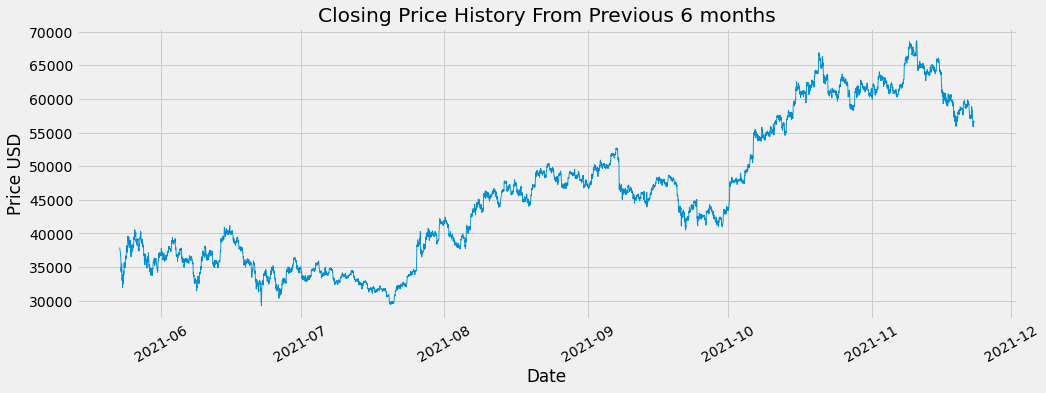

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title(f'Closing Price History From Previous {lookback}')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

In [95]:
# fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
#                 open=crypto_df['Open'],
#                 high=crypto_df['High'],
#                 low=crypto_df['Low'],
#                 close=crypto_df['Last'])])
# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

# code machine larning: Linear regresion and tecnical indicators and forward testing

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-05-22 20:30:00-05:00,37907.92
2021-05-22 21:00:00-05:00,37597.16
2021-05-22 21:30:00-05:00,37470.16
2021-05-22 22:00:00-05:00,37456.10
2021-05-22 22:30:00-05:00,37421.59
2021-05-22 23:00:00-05:00,37278.10
2021-05-22 23:30:00-05:00,37198.73
2021-05-23 00:00:00-05:00,36941.51
2021-05-23 00:30:00-05:00,36883.04


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)


In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-05-22 20:30:00-05:00,37907.92,34202.58
2021-05-22 21:00:00-05:00,37597.16,35211.89
2021-05-22 21:30:00-05:00,37470.16,35004.81
2021-05-22 22:00:00-05:00,37456.10,35472.97
2021-05-22 22:30:00-05:00,37421.59,35389.10
2021-05-22 23:00:00-05:00,37278.10,35031.00
2021-05-22 23:30:00-05:00,37198.73,33944.77
2021-05-23 00:00:00-05:00,36941.51,33005.67
2021-05-23 00:30:00-05:00,36883.04,33642.07


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-22 11:00:00-06:00,57497.26,56666.39
2021-11-22 11:30:00-06:00,57439.62,NaN
2021-11-22 12:00:00-06:00,57147.68,NaN
2021-11-22 12:30:00-06:00,56440.81,NaN
2021-11-22 13:00:00-06:00,56183.38,NaN
2021-11-22 13:30:00-06:00,55993.03,NaN
2021-11-22 14:00:00-06:00,55994.24,NaN
2021-11-22 14:30:00-06:00,55850.59,NaN
2021-11-22 15:00:00-06:00,55849.70,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[37907.92]
 [37597.16]
 [37470.16]
 ...
 [57877.5 ]
 [57716.56]
 [57497.26]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[34202.58 35211.89 35004.81 ... 56715.09 56596.01 56666.39]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

## linear regression similarity

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8487735198229431


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[57439.62]
 [57147.68]
 [56440.81]
 [56183.38]
 [55993.03]
 [55994.24]
 [55850.59]
 [55849.7 ]
 [56240.  ]
 [56278.7 ]
 [56700.02]
 [56385.27]
 [56247.18]
 [56715.09]
 [56596.01]
 [56666.39]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[57480.11846044 57188.47921913 56482.33744167 56225.17264791
 56035.01874784 56036.22750129 55892.72549055 55891.83640744
 56281.73431758 56320.39444856 56741.28040167 56426.85465938
 56288.90692069 56756.33487645 56637.37755352 56707.68504754]


## price results with machine learning prediction

In [57]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

# date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
# previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df = price_results_df.astype(float)
price_results_df.head(17)

,actual_price,predicted_price,previously_predicted_price
0,57439.62,57480.118460,57200.506306
1,57147.68,57188.479219,57259.945892
2,56440.81,56482.337442,58893.570304
3,56183.38,56225.172648,58251.744680
4,55993.03,56035.018748,58284.576833
5,55994.24,56036.227501,58202.126764
6,55850.59,55892.725491,58234.998883
7,55849.70,55891.836407,57917.977770
8,56240.00,56281.734318,57757.174159
9,56278.70,56320.394449,57538.060004


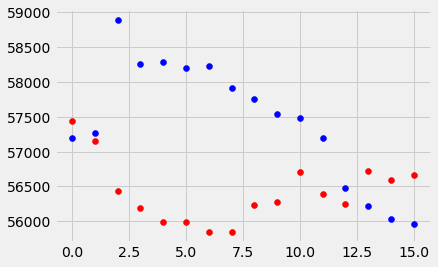

In [79]:
plt.scatter(price_results_df.index,price_results_df.actual_price, color='r', label='actual')
plt.scatter(price_results_df.index, price_results_df.previously_predicted_price, color='b', label='previous')
plt.show()

In [80]:
# for i in range(len(price_results_df)):
#     print(price_results_df.actual_price[i])
correlation = []
for i in range(len(price_results_df)):
    x=(abs(price_results_df.actual_price[i]-\
       price_results_df.previously_predicted_price[i]))/price_results_df.actual_price[i]
    correlation.append(x)

In [81]:
pd.DataFrame(correlation).describe()

,0
count,16.000000
mean,0.022438
std,0.015490
min,0.001964
25%,0.009592
50%,0.018314
75%,0.037632
max,0.043457


In [58]:
price_results_df.corr()

,actual_price,predicted_price,previously_predicted_price
actual_price,1.000000,1.000000,-0.473883
predicted_price,1.000000,1.000000,-0.473883
previously_predicted_price,-0.473883,-0.473883,1.000000


In [21]:
results_df.describe()

,predicted_price
count,16.000000
mean,56462.030259
std,445.203062
min,55891.836407
25%,56177.936361
50%,56373.624554
75%,56716.083886
max,57480.118460


In [94]:
price_results_df.actual_price.describe()

count       16.000000
mean     56420.481875
std        445.662186
min      55849.700000
25%      56136.095000
50%      56331.985000
75%      56674.797500
max      57439.620000
Name: actual_price, dtype: float64

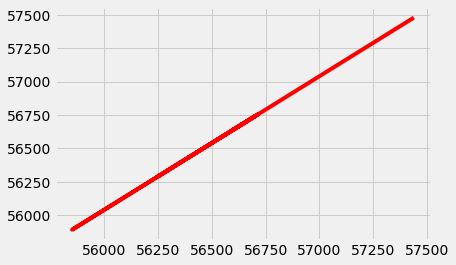

In [22]:
plt.plot(a_projection,Lreg_predict, color='r')

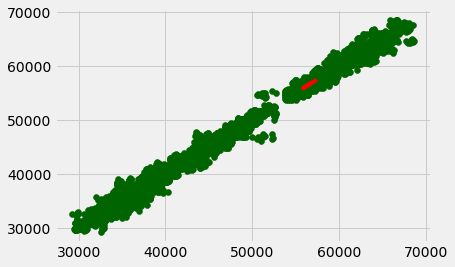

In [23]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [24]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

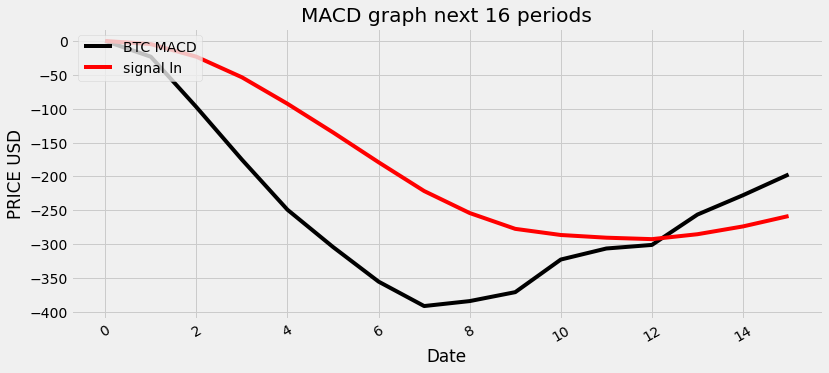

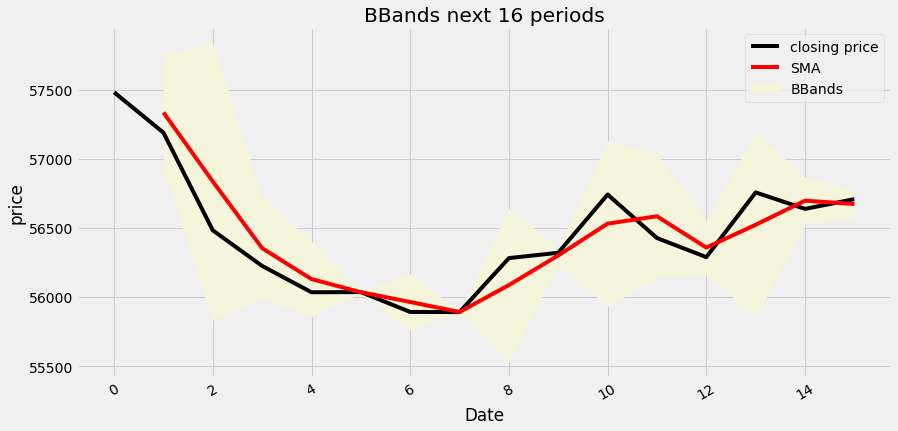

In [25]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [26]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
    crypto_buy_price = []
    crypto_sell_price = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            crypto_sell_price.append(np.nan)
            if flag != 1:
                buy.append('1')
                crypto_buy_price.append(signal['predicted_price'][i])
                flag = 1
            else:
                buy.append(np.nan)
                crypto_buy_price.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            crypto_buy_price.append(np.nan)
            if flag != 0:
                sell.append('1')
                crypto_sell_price.append(signal['predicted_price'][i])
                flag = 0
            else:
                sell.append(np.nan)
                crypto_sell_price.append(np.nan)
        else:
            buy.append(np.nan)
            crypto_buy_price.append(np.nan)
            sell.append(np.nan)
            crypto_sell_price.append(np.nan)
    return(buy, sell, crypto_buy_price, crypto_sell_price)
            

In [27]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[57439.62],57480.118460,57480.118460,57480.118460,0.000000,0.000000
1,[57147.68],57188.479219,57435.250885,57458.515554,-23.264669,-4.652934
2,[56440.81],56482.337442,57288.648817,57386.206064,-97.557247,-23.233796
3,[56183.38],56225.172648,57125.037098,57300.203589,-175.166490,-53.620335
4,[55993.03],56035.018748,56957.341968,57206.486193,-249.144225,-92.725113
5,[55994.24],56036.227501,56815.632050,57119.800364,-304.168314,-135.013753
6,[55850.59],55892.725491,56673.646425,57028.905929,-355.259504,-179.062904
7,[55849.7],55891.836407,56553.367961,56944.678557,-391.310596,-221.512442
8,[56240.0],56281.734318,56511.578170,56895.571576,-383.993407,-254.008635
9,[56278.7],56320.394449,56482.165289,56852.965863,-370.800574,-277.367023


In [28]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['Buy_Notification'] = x[0]
crypto_MACD_ML_df['Sell_Notification'] = x[1]
crypto_MACD_ML_df['Crypto_buy_price'] = x[2]
crypto_MACD_ML_df['Crypto_sell_price'] = x[3]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['Buy_Notification', 'Sell_Notification',
                                                   'Crypto_buy_price','Crypto_sell_price' ]]
crypto_MACD_ML_BuySell_Sig_df.fillna(0).head(50)

,Buy_Notification,Sell_Notification,Crypto_buy_price,Crypto_sell_price
0,0,0,0.000000,0.000000
1,0,1,0.000000,57188.479219
2,0,0,0.000000,0.000000
3,0,0,0.000000,0.000000
4,0,0,0.000000,0.000000
5,0,0,0.000000,0.000000
6,0,0,0.000000,0.000000
7,0,0,0.000000,0.000000
8,0,0,0.000000,0.000000
9,0,0,0.000000,0.000000


## BBand ML notification

In [29]:
crypto_ML_BBand_df = results_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 2

# calculate SMA
crypto_ML_BBand_df['SMA']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).mean()
#calculate std
crypto_ML_BBand_df['STD']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).std()
#calculate BB UP
crypto_ML_BBand_df['BBand Upper']=crypto_ML_BBand_df['SMA']+(crypto_ML_BBand_df['STD']*2)
#calculate BB LOW
crypto_ML_BBand_df['BBand Lower']=crypto_ML_BBand_df['SMA']-(crypto_ML_BBand_df['STD']*2)

crypto_ML_BBand_df.head()

,actual_price,predicted_price,SMA,STD,BBand Upper,BBand Lower
0,[57439.62],57480.118460,NaN,NaN,NaN,NaN
1,[57147.68],57188.479219,57334.298840,206.220085,57746.739010,56921.858669
2,[56440.81],56482.337442,56835.408330,499.317639,57834.043609,55836.773052
3,[56183.38],56225.172648,56353.755045,181.842970,56717.440984,55990.069106
4,[55993.03],56035.018748,56130.095698,134.459112,56399.013922,55861.177473


In [30]:
#buy sell signal
def alert_ML_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['predicted_price'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['predicted_price'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [31]:
#create buy and sell columns in df
x=alert_ML_BBands(crypto_ML_BBand_df)
crypto_ML_BBand_df['Buy_Notification'] = x[0]
crypto_ML_BBand_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_ML_BBand_BuySell_Sig_df = crypto_ML_BBand_df[['Buy_Notification', 'Sell_Notification']]
crypto_ML_BBand_BuySell_Sig_df.fillna(0).head(17)

,Buy_Notification,Sell_Notification
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Techincal indicators strategy

## MACD df

In [32]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date_and_Time,,,,,,,,,
2021-11-22 09:30:00-06:00,58161.89,58238.29,57937.03,58194.79,859.04709,57885.190462,57833.882651,51.307811,-103.303161
2021-11-22 10:00:00-06:00,58194.78,58250.00,57620.00,57877.50,1290.45752,57884.007314,57837.113566,46.893748,-73.263779
2021-11-22 10:30:00-06:00,57877.50,57993.52,57620.00,57716.56,670.78674,57858.246189,57828.183672,30.062516,-52.598520
2021-11-22 11:00:00-06:00,57716.56,57776.88,57463.93,57497.26,743.46095,57802.709852,57803.670808,-0.960956,-42.271007
2021-11-22 11:30:00-06:00,57497.27,57519.65,57288.48,57439.62,777.23164,57746.849875,57776.704081,-29.854206,-39.787647
2021-11-22 12:00:00-06:00,57439.62,57439.62,57124.37,57147.68,749.77743,57654.669894,57730.109705,-75.439811,-46.918080
2021-11-22 12:30:00-06:00,57147.68,57206.04,56404.66,56440.81,1934.84718,57467.922218,57634.606023,-166.683805,-70.871225
2021-11-22 13:00:00-06:00,56440.81,57082.99,56153.94,56183.38,2091.77487,57270.300338,57527.107799,-256.807461,-108.058472
2021-11-22 13:30:00-06:00,56183.37,56438.96,55800.00,55993.03,1983.99702,57073.797209,57413.472406,-339.675197,-154.381817


## MACD buy and sell notification

In [33]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [34]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['Buy_Notification'] = x[0]
crypto_MACD_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['Buy_Notification', 'Sell_Notification']]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-22 19:00:00-06:00,0,0
2021-11-22 18:30:00-06:00,0,0
2021-11-22 18:00:00-06:00,1,0
2021-11-22 17:30:00-06:00,0,0
2021-11-22 17:00:00-06:00,0,0
2021-11-22 16:30:00-06:00,0,0
2021-11-22 16:00:00-06:00,0,0
2021-11-22 15:30:00-06:00,0,0
2021-11-22 15:00:00-06:00,0,0


## BOLLINGER BANDS df

In [35]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.head(30)

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date_and_Time,,,,,,,,,
2021-05-22 20:30:00-05:00,38139.86,38190.00,37871.84,37907.92,1248.865544,NaN,NaN,NaN,NaN
2021-05-22 21:00:00-05:00,37907.91,38018.93,37520.00,37597.16,1288.798796,NaN,NaN,NaN,NaN
2021-05-22 21:30:00-05:00,37597.15,37818.87,37370.01,37470.16,1612.494279,NaN,NaN,NaN,NaN
2021-05-22 22:00:00-05:00,37470.54,37645.28,37234.40,37456.10,1413.554710,NaN,NaN,NaN,NaN
2021-05-22 22:30:00-05:00,37456.09,37663.64,37366.72,37421.59,1221.207909,NaN,NaN,NaN,NaN
2021-05-22 23:00:00-05:00,37421.59,37421.59,37050.66,37278.10,1534.696269,NaN,NaN,NaN,NaN
2021-05-22 23:30:00-05:00,37278.09,37413.53,37102.00,37198.73,1252.048667,NaN,NaN,NaN,NaN
2021-05-23 00:00:00-05:00,37198.73,37198.73,36572.41,36941.51,3063.573761,NaN,NaN,NaN,NaN
2021-05-23 00:30:00-05:00,36941.51,37089.00,36877.94,36883.04,1362.363186,NaN,NaN,NaN,NaN


## BBand buy sell Notification

In [36]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [37]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['Buy_Notification'] = x[0]
crypto_BBand_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['Buy_Notification', 'Sell_Notification']]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(50)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-22 19:00:00-06:00,0,0
2021-11-22 18:30:00-06:00,0,0
2021-11-22 18:00:00-06:00,0,0
2021-11-22 17:30:00-06:00,0,0
2021-11-22 17:00:00-06:00,0,0
2021-11-22 16:30:00-06:00,0,0
2021-11-22 16:00:00-06:00,0,0
2021-11-22 15:30:00-06:00,0,0
2021-11-22 15:00:00-06:00,0,0


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [38]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['Buy_Notification'][i] == df2['Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['Sell_Notification'][i]== df2['Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [39]:
#create buy and sell columns in df
x=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = x[0]
crypto_alert_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(59)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-22 19:00:00-06:00,0,0
2021-11-22 18:30:00-06:00,0,0
2021-11-22 18:00:00-06:00,0,0
2021-11-22 17:30:00-06:00,0,0
2021-11-22 17:00:00-06:00,0,0
2021-11-22 16:30:00-06:00,0,0
2021-11-22 16:00:00-06:00,0,0
2021-11-22 15:30:00-06:00,0,0
2021-11-22 15:00:00-06:00,0,0


In [40]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [41]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [42]:
crypto_df['Last'].describe()

count     8819.000000
mean     45732.403640
std      10500.004475
min      29238.990000
25%      36187.060000
50%      44960.370000
75%      54500.700000
max      68633.690000
Name: Last, dtype: float64

## Technical Indicators graphs

In [43]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title(f'MACD graph from previous {lookback}')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous 8 hours')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    
    
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title(f'BBands previous {lookback}')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour, now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last 8 hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

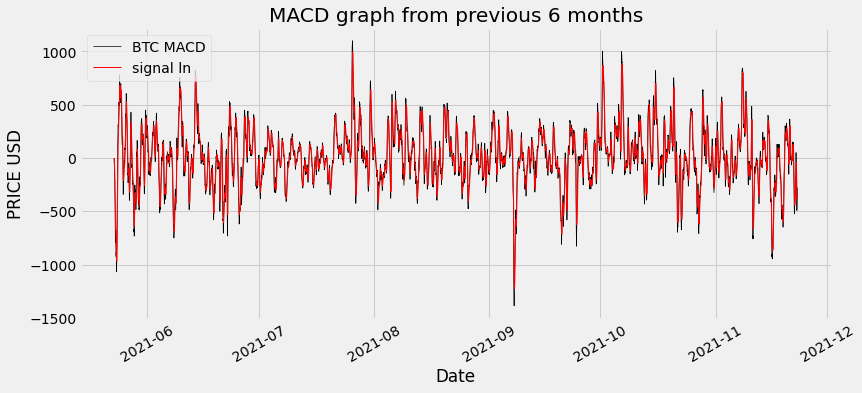

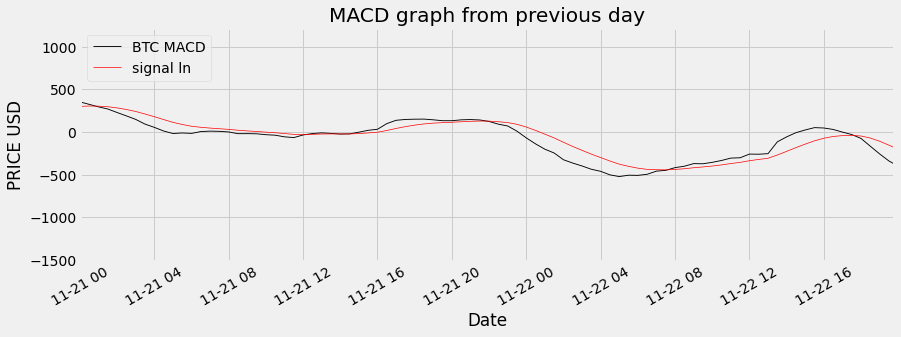

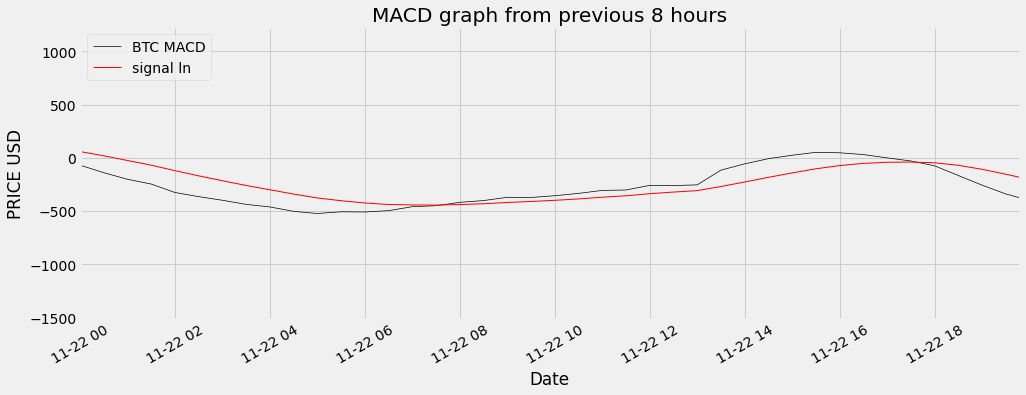

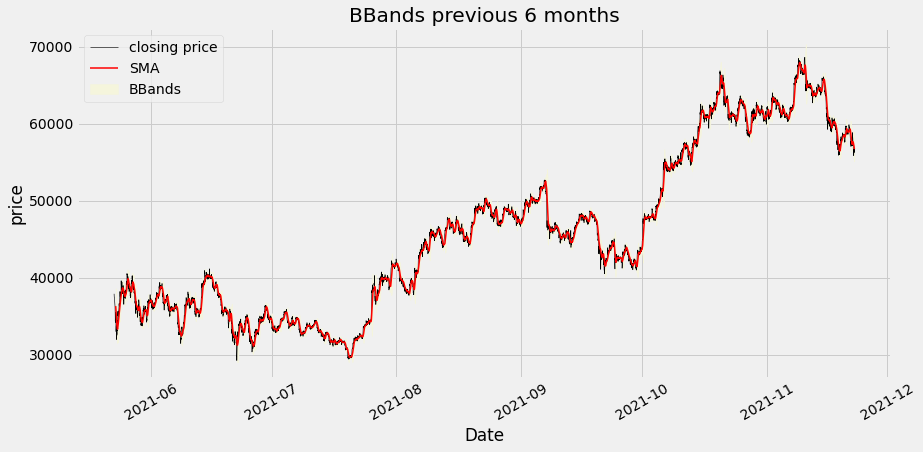

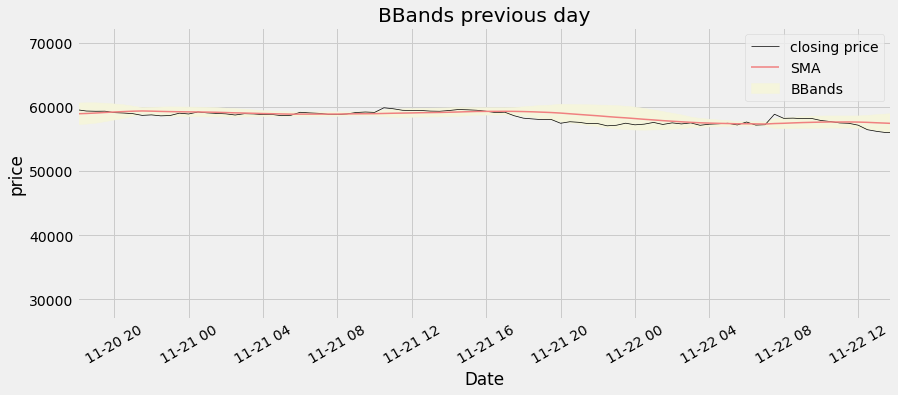

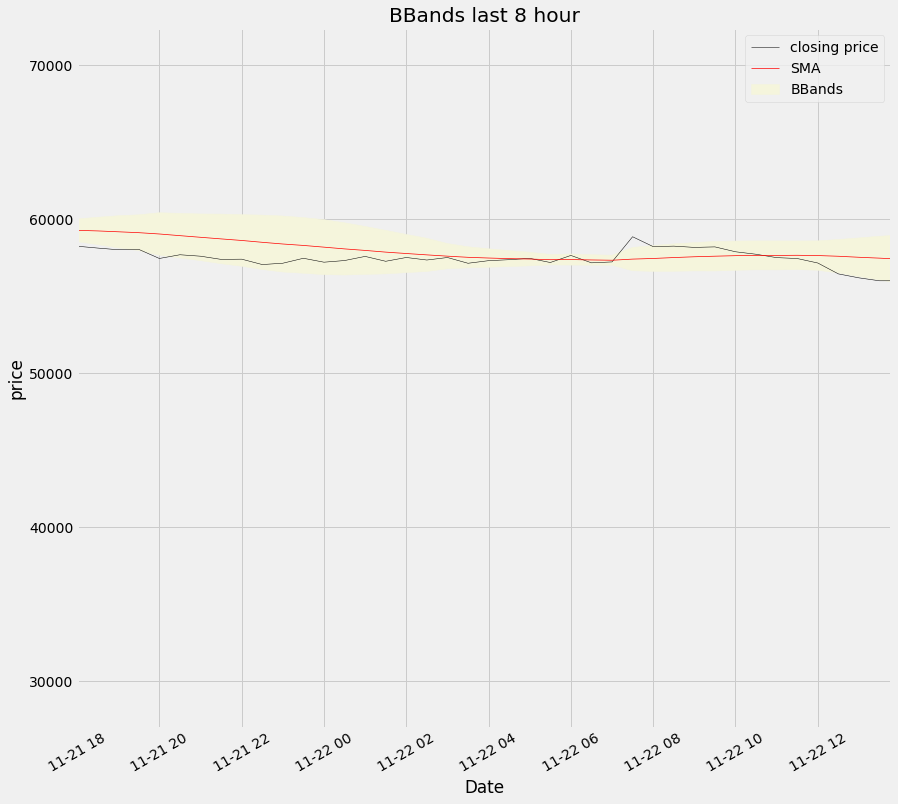

In [85]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [86]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [87]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [88]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


Date_and_Time
2021-05-23 14:30:00-05:00    33184.12
2021-05-24 15:00:00-05:00    39606.11
2021-05-25 10:00:00-05:00    37634.62
2021-05-26 17:00:00-05:00    39030.74
2021-05-27 01:30:00-05:00    38065.49
                               ...   
2021-11-20 12:30:00-06:00    59380.71
2021-11-21 07:00:00-06:00    59057.99
2021-11-21 09:00:00-06:00    58895.00
2021-11-22 02:30:00-06:00    57506.65
2021-11-22 18:30:00-06:00    56715.09
Name: Open, Length: 341, dtype: float64

In [89]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

Date_and_Time
2021-05-24 11:00:00-05:00    37539.64
2021-05-24 17:30:00-05:00    38472.83
2021-05-26 05:30:00-05:00    39581.33
2021-05-26 20:30:00-05:00    38202.32
2021-05-27 11:30:00-05:00    39130.16
                               ...   
2021-11-19 23:00:00-06:00    58486.71
2021-11-20 19:30:00-06:00    59317.33
2021-11-21 08:30:00-06:00    58794.98
2021-11-21 16:30:00-06:00    59319.11
2021-11-22 12:30:00-06:00    57147.68
Name: Open, Length: 340, dtype: float64

In [90]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [91]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [92]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()


,0
count,340.000000
mean,0.000862
std,0.022064
min,-0.062218
25%,-0.010190
50%,-0.004861
75%,0.005704
max,0.131253
